In [ ]:
!pip install -qU langgraph langchain langchain-openai langchain-deepseek 
!pip install -qU pydantic typing-extensions

In [46]:
from typing import Dict, Any, List, Optional, Annotated
from typing_extensions import TypedDict
from langgraph.graph import START, END, StateGraph
from datetime import datetime
import json
import logging
import os
from pathlib import Path
from pydantic import BaseModel, Field
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage
from langchain_openai import ChatOpenAI
from langchain_deepseek import ChatDeepSeek
from langchain_qwq import ChatQwen

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)


# === Define state ===
class AgentState(TypedDict):
    xmind_context: str
    expand_instructions: str
    product_proposal: str
    prototype_instructions: str
    prototype_html: str
    prd_instructions: str
    prd_template: str
    prd_document: str
    label_instructions:str
    labelled_html:str



In [47]:
# === LLM management ===
exec(open('config.py').read())
from config import Config

class LLM_expand:
    """xmind expand LLM"""
    
    def __init__(self):
        self.config = Config.EXPAND_MODEL_CONFIG
        self._initialize_llm()
    
    def _initialize_llm(self):
        try:
            self.llm = ChatOpenAI(
                model=self.config["model"],
                api_key=self.config["api_key"],
                temperature=self.config["temperature"],
                base_url=self.config["base_url"],
                max_tokens=self.config["max_tokens"]
            )
            logger.info(f"LLM initialization is successful: {self.config['model']}")
        except Exception as e:
            logger.error(f"LLM initialization is failed: {e}")
            raise
    
    def invoke(self, messages: List, **kwargs) -> str:
        try:
            response = self.llm.invoke(messages, **kwargs)
            return response.content
        except Exception as e:
            logger.error(f"LLM calling is failed: {e}")
            raise
    
    def analyze(self, content: str, prompt: str) -> str:
        messages = [
            SystemMessage(content="You are an experienced software product manager."),
            HumanMessage(content=f"{prompt}\n\n{content}")
        ]
        return self.invoke(messages)

class LLM_prototype:
    """prototype LLM"""
    
    def __init__(self):
        self.config = Config.PROTOTYPE_MODEL_CONFIG
        self._initialize_llm()
    
    def _initialize_llm(self):
        try:
            self.llm = ChatOpenAI(
                model=self.config["model"],
                api_key=self.config["api_key"],
                temperature=self.config["temperature"],
                base_url=self.config["base_url"],
                max_tokens=self.config["max_tokens"]
            )
            logger.info(f"LLM initialization is successful: {self.config['model']}")
        except Exception as e:
            logger.error(f"LLM initialization is failed: {e}")
            raise
    
    def invoke(self, messages: List, **kwargs) -> str:
        try:
            response = self.llm.invoke(messages, **kwargs)
            return response.content
        except Exception as e:
            logger.error(f"LLM calling is failed: {e}")
            raise
    def analyze(self, content: str, prompt: str) -> str:
        messages = [
            SystemMessage(content="You are an experienced UI designer skilled at transforming product managers' requirements into user-friendly, visually appealing high-fidelity prototypes."),
            HumanMessage(content=f"{prompt}\n\n{content}")
        ]
        return self.invoke(messages)

class LLM_prd:
    """prd LLM"""
    
    def __init__(self):
        self.config = Config.PRD_MODEL_CONFIG
        self._initialize_llm()
    
    def _initialize_llm(self):
        try:
            self.llm = ChatOpenAI(
                model=self.config["model"],
                api_key=self.config["api_key"],
                temperature=self.config["temperature"],
                base_url=self.config["base_url"],
                max_tokens=self.config["max_tokens"]
            )
            logger.info(f"LLM initialization is successful: {self.config['model']}")
        except Exception as e:
            logger.error(f"LLM initialization is failed: {e}")
            raise
    
    def invoke(self, messages: List, **kwargs) -> str:
        try:
            response = self.llm.invoke(messages, **kwargs)
            return response.content
        except Exception as e:
            logger.error(f"LLM calling is failed: {e}")
            raise
    def analyze(self, content: str, prompt: str) -> str:
        messages = [
            SystemMessage(content="You are a product manager skilled at writing documentation in both Chinese and English. Your goal is to produce PRDs that are precise, logical, and grammatically sound. You can switch your thinking language based on the input language and produce content accordingly."),
            HumanMessage(content=f"{prompt}\n\n{content}")
        ]
        return self.invoke(messages)

In [48]:
# === workflow ===
# step 1 expand xmind context to proposal
expand_instructions = """You are a Product Analyst Agent. Your goal is to transform Xmind mind-map content (formatted as Markdown) into a structured Product Proposal.

INSTRUCTIONS
1. Context Analysis: Analyze the hierarchical structure. Treat top-level nodes as Modules and leaf nodes as Features/Logic.
2. Logic vs. UI: Distinguish between physical features (pages, buttons) and abstract business logic (processes, goals).
3. LANGUAGE FIDELITY:
Detect the primary language of the Xmind input.
Strictly use that same language for all output content (feature names, descriptions, logic).
Do NOT translate terms into English.
4. Strict Constraints:
Cover 100% of the nodes mentioned.
DO NOT hallucinate features not mentioned.

OUTPUT FORMAT
Generate a structured report in Markdown (headers in English is fine, content must be Source Language):

1. Product Scope
(Summary in Source Language)

2. Module Breakdown
Module Name: [Node Title in Source Language]
Functional Features: [UI items in Source Language]
Business Logic: [Rules in Source Language]
Data/Fields: [Data points in Source Language]

3. Non-Functional Requirements
(Optimization goals in Source Language)
"""

def expand_mindmap(state: AgentState):
    messages = [
        SystemMessage(content=expand_instructions), 
        HumanMessage(content=f"{state['xmind_context']}")
    ]
    llm = LLM_expand()  # Instantiate the LLM class
    response = llm.invoke(messages)  # Call invoke method with messages
    return {
        "xmind_context": state['xmind_context'], 
        "product_proposal": response  
    }


# step 2 proposal to prototype
prototype_instructions = """
You are an Expert UI/UX Engineer. Your goal is to transform a Product Proposal into a High-Fidelity HTML/CSS Prototype.

INPUTS
Proposal: Structured requirements.
Style: Design System.

LIBRARIES
CSS: Tailwind CSS (CDN).
Icons: FontAwesome (CDN).
Images: Unsplash.

INSTRUCTIONS
UI LANGUAGE (CRITICAL):
Use the EXACT language found in the Input Proposal for all visible text.
Buttons: Use "提交" if input is Chinese, "Submit" if English.
Placeholders: Use "请输入..." if input is Chinese.
Do NOT use English defaults.
Structure: Sidebar (Nav) + Main Content Area + Cards for Features.
Design System: Apply the requested Style (colors, spacing, shadows).
Content Mapping:
Convert "Functional Features" to Buttons/Inputs.
Render "Business Logic" as Tooltips or Info Alerts.
Output: Return ONLY single, valid, self-contained HTML/CSS/JS. <!DOCTYPE html> should be in the beginning of your output.

EXECUTION
Generate the HTML prototype now.
"""
def draw_prototype(state: AgentState):
    messages = [
        SystemMessage(content=prototype_instructions), 
        HumanMessage(content=f"{state['product_proposal']}")
    ]
    llm = LLM_prototype()  # Instantiate the LLM class
    response = llm.invoke(messages)  # Call invoke method with messages
    return {"prototype_html": response}  

# step 3 proposal to prd
prd_instructions = """
You are a Senior Product Manager. Your task is to write a comprehensive Product Requirements Document (PRD) based on a provided Product Proposal and a specific Template in HUMAN MESSAGE.

MAPPING RULES
Functional Features: Map to "Functional Requirements" or "User Interactions."
Data/Fields: Map to "Data Requirements" or "Page Elements."
Business Logic: Map to "Backend Logic," "Algorithms," or "Flow Rules."
Non-Functional: Map optimization goals (e.g., "speed," "standardization") to "Success Metrics" or "Non-Functional Requirements."
INSTRUCTIONS
Strict Template Adherence: Output the PRD exactly in the provided template format. Do not change headers.
No Feature Creep: Do not invent new modules. Only elaborate on standard behaviors implied by the proposal (e.g., validation, error states, loading states).
Clarity: Use clear, unambiguous technical language. Use bolding for key terms.
EXECUTION
Receive the Proposal and Template, then generate the PRD.
The output should use the same language as the human message.
"""
with open('prd_template.md', 'r', encoding='utf-8') as file:
    prd_template = file.read()

def write_prd(state: AgentState):
    messages = [
        SystemMessage(content=prd_instructions), 
        HumanMessage(content=f"""
    the product proposal: {state['product_proposal']}
    the prd example: {prd_template}
    """)
    ]
    llm = LLM_prd()  
    response = llm.invoke(messages)  
    return {"prd_document": response}  

# step 4 label the prototype
label_instructions = """You are a Senior Interaction Designer and Frontend Architect. Your task is to transform the Static HTML Prototype from the previous step into a fully Interactive PRD/Annotation Tool.

INPUT
1. Source Code: The High-Fidelity HTML generated in Step 2.

OBJECTIVE
Output a single HTML file that renders the original UI plus an overlay layer of interactive specification annotations.

CORE WORKFLOW
1. Element Recognition & Logic Writing (The "UX Brain")
Analyze the HTML structure. Identify every interactive element (Inputs, Buttons, Cards, Navigation). For each, generate a JSON object in the script with:
Target: The CSS selector of the element.
Title: Name of the element (e.g., "Submit Button").
Description: Strict logic definition. Format: [Normal Flow] + [Edge Case/Empty State]. Example: "Click to submit. If network fails, show toast error. If field empty, disable button."

2. Layout Strategy (The "UI Layout")
Screen Split: Elements on the Left half -> Place Annotation Card on the Far Left margin. Elements on the Right half -> Place Annotation Card on the Far Right margin.
Vertical Flow: Calculate offsetTop to align cards roughly with their targets, but apply spacing to prevent overlap.

3. Tool Functionality (The "Frontend Logic")
You must inject JavaScript and CSS to achieve the following strictly:
Visuals: Draw an SVG line from the element to the Annotation Card. The line start-point (on the UI element) must be a distinct Dot. The line end-point must touch the Annotation Card perfectly (no gaps).
Interactivity (CRITICAL):
Draggable: Users must be able to drag the Annotation Cards AND the Line Start-Dots to adjust positions manually.
Editable: All text inside the Annotation Cards must be contenteditable. Clicking text allows direct modification.
Re-rendering: The connecting lines must update automatically when cards or dots are dragged.

OUTPUT REQUIREMENTS
1. Code Only: Return a single, valid HTML code block.
2. Coverage: Annotate at least 80% of visible elements.
3. Self-Check: Ensure z-index of the annotation layer is highest (9999). Ensure text color contrasts with the background. Verify the script handles "No Data" logic in the text descriptions.

EXECUTION
Take the human message HTML, inject the annotation script/styles, and output the final result.
The labels and notes should use the same language as the humanmessage.
"""
def label_prototype(state: AgentState):
    messages = [
        SystemMessage(content=label_instructions), 
        HumanMessage(content=f"{state['prototype_html']}")
    ]
    llm = LLM_prototype()  
    response = llm.invoke(messages)  
    return {"labelled_html": response}  

# step 5 save files
def save_files(state: AgentState):
    logger.info("saving outputs...")
    updates = {}
    try:
        output_dir = Path("output")
        output_dir.mkdir(exist_ok=True)
        
        # save prototype
        if state.get("prototype_html"):
            with open(output_dir / "prototype.html", "w", encoding="utf-8") as f:
                f.write(state["prototype_html"])
        
        # save prd doc
        if state.get("prd_document"):
            with open(output_dir / "prd_document.md", "w", encoding="utf-8") as f:
                f.write(state["prd_document"])
        
        # save labelled prototype
        if state.get("labelled_html"):
            with open(output_dir / "labelled_prototype.html", "w", encoding="utf-8") as f:
                f.write(state["labelled_html"])
        
        logger.info(f"files saved to: {output_dir}")
        
    except Exception as e:
        updates["error_messages"] = f"failed to save files: {e}"
        logger.error(f"failed to save files: {e}")
    
    return updates

# === Build graph ===
workflow_builder = StateGraph(AgentState)
workflow_builder.add_node("expand_mindmap", expand_mindmap)
workflow_builder.add_node("draw_prototype", draw_prototype)
workflow_builder.add_node("write_prd", write_prd)
workflow_builder.add_node("label_prototype", label_prototype)
workflow_builder.add_node("save_files", save_files)

# === Define workflow ===
workflow_builder.add_edge(START, "expand_mindmap")
workflow_builder.add_edge("expand_mindmap", "draw_prototype")
workflow_builder.add_edge("draw_prototype", "write_prd")
workflow_builder.add_edge("write_prd", "label_prototype")
workflow_builder.add_edge("label_prototype", "save_files")
workflow_builder.add_edge("save_files", END)

# === compile graph
graph = workflow_builder.compile()

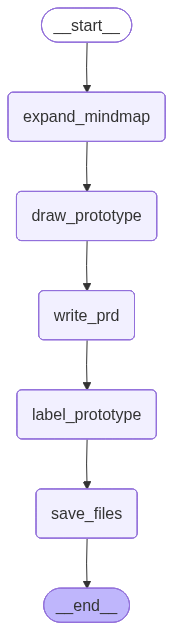

In [49]:
#=== show graph ===
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass


In [ ]:
# === If you changed config, uncomment below codes to reload Config and Re-run the LLMs above ===

# import importlib
# import config

# # Reload the config module to get latest changes
# importlib.reload(config)
# from config import Config

# print("✅ Config reloaded")
# print(f"Expand Model: {Config.EXPAND_MODEL_CONFIG['model']}")
# print(f"Prototype Model: {Config.PROTOTYPE_MODEL_CONFIG['model']}")
# print(f"PRD Model: {Config.PRD_MODEL_CONFIG['model']}")

In [ ]:
# replace the file name of your xmind context
with open('xminds/my_new_feature.md', 'r', encoding='utf-8') as file:
    xmind_context = file.read()

#Alternatively, you can paste your context right here, remember to uncomment the code below and comment the read file code above. 
# xmind_context = """


# """


initial_state = {
    "xmind_context": xmind_context,
    "expand_instructions": "",
    "product_proposal": "",
    "prototype_instructions": "",
    "prototype_html": "",
    "prd_instructions": "",
    "prd_template": "",
    "prd_document": "",
    "label_instructions": "",  
    "labelled_html": ""
}

result = graph.invoke(initial_state)


print("Product Proposal:\n", result.get("product_proposal", ""))
print("\nPrototype HTML:\n", result.get("prototype_html", ""))
print("\nPRD Document:\n", result.get("prd_document", ""))
print("\nLabelled HTML:\n", result.get("labelled_html", ""))